In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/New_Cat_Dog-20250830T051218Z-1-001.zip

Archive:  /content/New_Cat_Dog-20250830T051218Z-1-001.zip
  inflating: New_Cat_Dog/cat_dog_encoded_mask_jpg/dog124.jpg  
  inflating: New_Cat_Dog/cat_dog_encoded_mask_jpg/dog177.jpg  
  inflating: New_Cat_Dog/cat_dog_encoded_mask_jpg/dog186.jpg  
  inflating: New_Cat_Dog/cat_dog_encoded_mask_jpg/dog27.jpg  
  inflating: New_Cat_Dog/cat_dog_encoded_mask_jpg/dog185.jpg  
  inflating: New_Cat_Dog/cat_dog_encoded_mask_jpg/dog69.jpg  
  inflating: New_Cat_Dog/cat_dog_encoded_mask_jpg/dog21.jpg  
  inflating: New_Cat_Dog/cat_dog_encoded_mask_jpg/dog72.jpg  
  inflating: New_Cat_Dog/cat_dog_encoded_mask_jpg/dog161.jpg  
  inflating: New_Cat_Dog/cat_dog_encoded_mask_jpg/dog103.jpg  
  inflating: New_Cat_Dog/cat_dog_encoded_mask_jpg/dog74.jpg  
  inflating: New_Cat_Dog/cat_dog_encoded_mask_jpg/dog118.jpg  
  inflating: New_Cat_Dog/cat_dog_encoded_mask_jpg/dog158.jpg  
  inflating: New_Cat_Dog/cat_dog_encoded_mask_jpg/dog35.jpg  
  inflating: New_Cat_Dog/cat_dog_encoded_mask_jpg/dog17.jpg  
  in

In [ ]:
import tensorflow as tf
import os

IMAGE_DIR = "/content/New_Cat_Dog/JPEGImages_dog_cat"
MASK_DIR = "/content/New_Cat_Dog/cat_dog_encoded_mask_jpg"

image_filenames = sorted(os.listdir(IMAGE_DIR))

mask_paths = [
    os.path.join(MASK_DIR, fname.replace(".jpg", "_mask.jpg"))
    for fname in image_filenames
]

image_paths = [os.path.join(IMAGE_DIR, fname) for fname in image_filenames]
full_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))



In [4]:
image_filenames = sorted(os.listdir(IMAGE_DIR))
image_paths = [os.path.join(IMAGE_DIR, fname) for fname in image_filenames]
mask_paths = [os.path.join(MASK_DIR, fname) for fname in image_filenames]


# Create the initial dataset of file path pairs
full_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))


In [5]:
DATASET_SIZE = len(image_paths)
TRAIN_SIZE = int(0.8 * DATASET_SIZE) # 80% for training
VAL_SIZE = DATASET_SIZE - TRAIN_SIZE # 20% for validation


full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)

train_dataset = full_dataset.take(TRAIN_SIZE)
val_dataset = full_dataset.skip(TRAIN_SIZE)

print(f"Total examples: {DATASET_SIZE}")
print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")

Total examples: 401
Training examples: 320
Validation examples: 81


In [6]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [7]:
def load_and_preprocess(img_path, label_path):
    # 1. Read and decode the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize pixel values to be between 0 and 1
    img = tf.cast(img, tf.float32) / 255.0

    # 2. Read and decode the label (mask)
    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    # Use 'nearest' neighbor resizing for masks to avoid creating new class values
    label = tf.image.resize(label, [IMG_HEIGHT, IMG_WIDTH], method='nearest')

    return img, label

In [8]:
BATCH_SIZE = 32
BUFFER_SIZE = 200

In [9]:
train_batches = (
    train_dataset
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()  # Cache data for faster subsequent epochs
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat() # Repeat the dataset indefinitely
    .prefetch(buffer_size=tf.data.AUTOTUNE) # Prepares the next batches while the current one is processed
)

In [10]:
val_batches = (
    val_dataset
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


--- Verifying a batch ---
Images batch shape: (32, 128, 128, 3)
Labels batch shape: (32, 128, 128, 1)


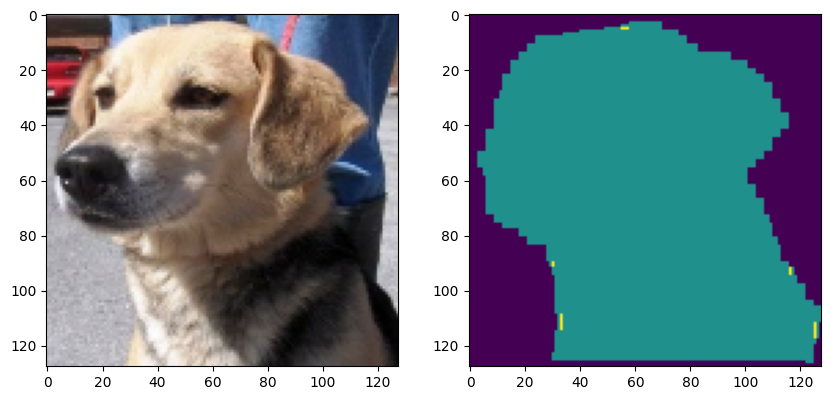

In [18]:
import matplotlib.pyplot as plt
temp_label =None
for images, labels in train_batches.take(1):
    print("\n--- Verifying a batch ---")
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    indx = 0

    temp_label = labels[indx]
    axes[0].imshow(images[indx])
    axes[1].imshow(labels[indx],cmap='viridis')
    break
plt.show()



In [19]:
import numpy as np
color_value_list = set()
label_numpy = temp_label.numpy()
unique_values = np.unique(label_numpy)
print(unique_values)


for row in range(IMG_WIDTH):
    for col in range(IMG_HEIGHT):
        color_value = label_numpy[row, col][0]
        color_value_list.add(color_value)

print(color_value_list)

[0 1 2]
{np.uint8(0), np.uint8(1), np.uint8(2)}


### Build the U-Net Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def build_unet_with_mobilenet(input_shape, num_classes):
    """
    Builds a U-Net model using a pre-trained MobileNetV2 as the encoder.
    (Corrected Version)
    """

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )


    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'out_relu',              # Bottleneck: 4x4
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model (the encoder)
    encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs, name="encoder")
    encoder.trainable = False



    #  Build the Decoder Path
    inputs = tf.keras.Input(shape=input_shape)
    skips = encoder(inputs)
    print("#"*30)
    for temp in skips:
        print(temp)

    print("#"*30)


    x = skips[-1]

    decoder_skips = reversed(skips[:-1])



    print("#"*30)
    for temp in decoder_skips:
        print(temp)
    print("#"*30)

    print(x)
    print("#"*30)

    decoder_skips = reversed(skips[:-1])  # skip connections except bottleneck

    for i, skip in enumerate(decoder_skips):
        x = layers.Conv2DTranspose(filters=512 // (2**i), kernel_size=2, strides=2, padding='same', activation='relu')(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters=512 // (2**i), kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(filters=512 // (2**i), kernel_size=3, padding='same', activation='relu')(x)

    # Final upsampling to match input size 128x128
    outputs = layers.Conv2DTranspose(
        filters=num_classes,
        kernel_size=2,
        strides=2,
        padding='same',
        activation='softmax'  # final output
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

def build_unet_with_mobilenet(input_shape, num_classes):
    """
    Builds a U-Net model using a pre-trained MobileNetV2 as the encoder.
    """
    # Load MobileNetV2 without the top classification layer
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Define layers for skip connections and the bottleneck
    layer_names = [
        'block_1_expand_relu',   # Output 1: 64x64
        'block_3_expand_relu',   # Output 2: 32x32
        'block_6_expand_relu',   # Output 3: 16x16
        'block_13_expand_relu',  # Output 4: 8x8
        'out_relu',              # Bottleneck: 4x4
    ]

    # Create the encoder model with outputs from the specified layers
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
    encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
    encoder.trainable = False

    # Define the decoder path
    inputs = tf.keras.Input(shape=input_shape)

    # Get feature maps from the encoder
    skips = encoder(inputs)
    x = skips[-1]  # The bottleneck output
    decoder_skips = reversed(skips[:-1])  # Reversed list of skip connections

    # Upsampling and concatenation loop
    for i, skip in enumerate(decoder_skips):
        filters = 512 // (2**i)
        x = layers.Conv2DTranspose(filters=filters, kernel_size=2, strides=2, padding='same')(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)

    # Final upsampling to match original input size
    # The last Conv2DTranspose layer upsamples from 64x64 to 128x128
    outputs = layers.Conv2DTranspose(
        filters=num_classes,
        kernel_size=2,
        strides=2,
        padding='same',
        activation='softmax'
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Example usage (you'll need to define your dataset loaders)
IMG_HEIGHT = 128
IMG_WIDTH = 128
NUM_CLASSES = 3  # background, cat, dog

model = build_unet_with_mobilenet((IMG_HEIGHT, IMG_WIDTH, 3), NUM_CLASSES)

# Model compilation is correct as written in the original prompt
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
NUM_CLASSES = 3
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
model = build_unet_with_mobilenet(input_shape, NUM_CLASSES)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ [(None, 64, 64,   │  2,257,984 │ input_layer_3[0]… │
│ (Functional)        │ 96), (None, 32,   │            │                   │
│                     │ 32, 144), (None,  │            │                   │
│                     │ 16, 16, 192),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 576), (None, 4,   │            │                   │
│                     │ 4, 1280)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 8, 8, 512) │  2,621,952 │ functional_2[0][… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 8, 8,      │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 1088)             │            │ functional_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 512) │  5,014,016 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 16, 16,    │    524,544 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 448)              │            │ functional_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │  1,032,448 │ concatenate_5[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_10[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 32, 32,    │    131,200 │ conv2d_11[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 272)              │            │ functional_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │    313,472 │ concatenate_6[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_12[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 64, 64,    │     32,832 │ conv2d_13[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 15,155,843 (57.81 MB)

 Trainable params: 12,897,859 (49.20 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
EPOCHS = 30
STEPS_PER_EPOCH = len(train_dataset) // BATCH_SIZE
print(STEPS_PER_EPOCH)

10


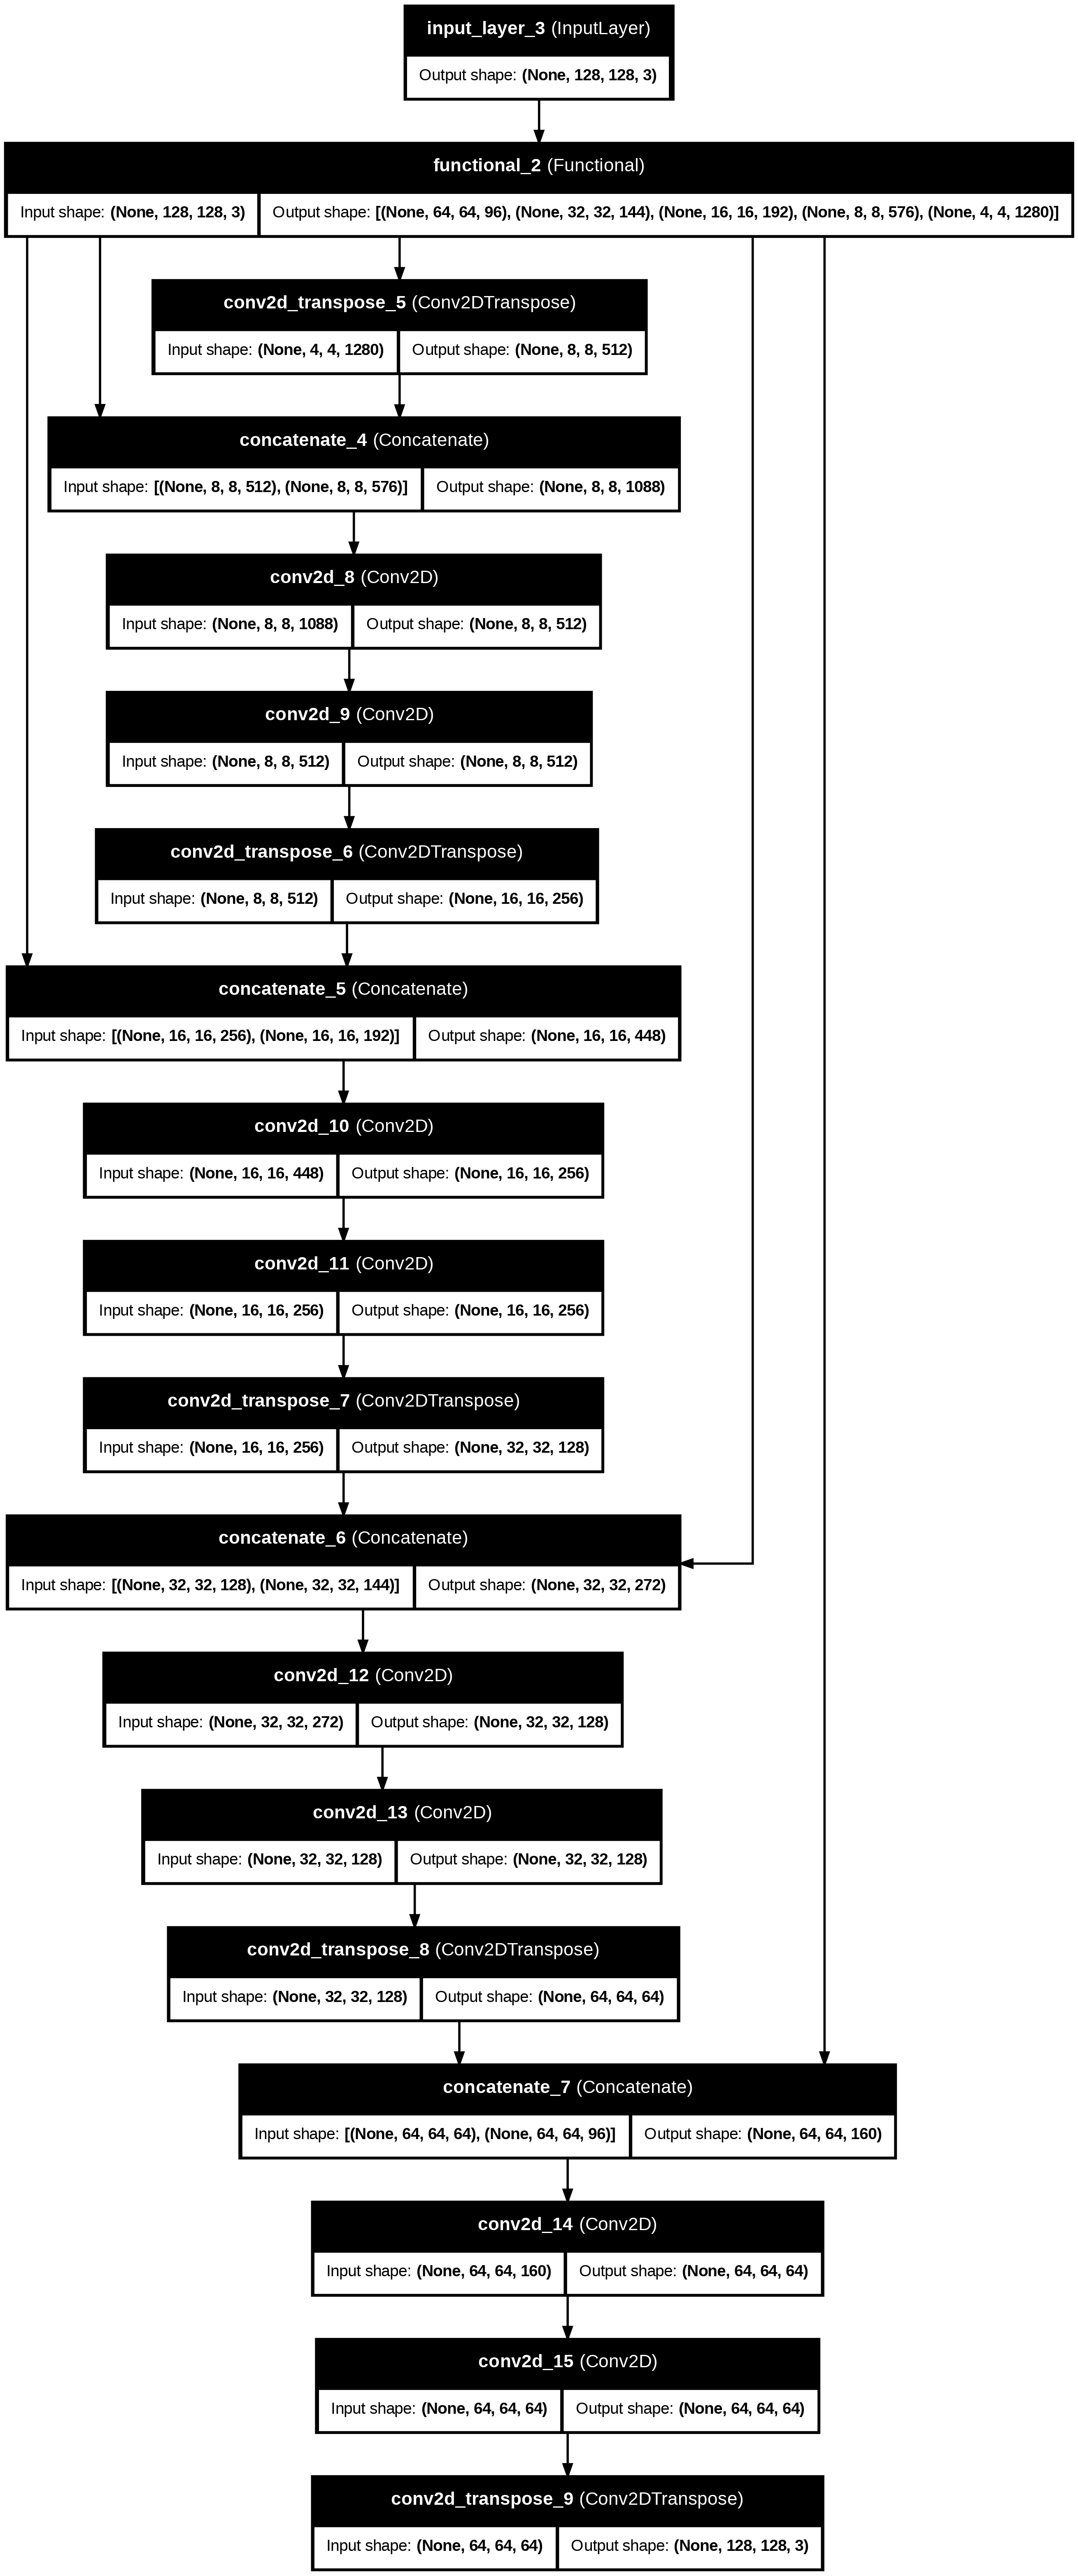

In [25]:
from tensorflow.keras.utils import plot_model

# pip install pydot
# Save model architecture as image
plot_model(model, to_file="tf_lr_model_architecture.png", show_shapes=True, show_layer_names=True)

In [26]:

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-4
)

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_batches,
    callbacks=[lr_scheduler]
)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.5061 - loss: 0.8816 - val_accuracy: 0.6006 - val_loss: 0.6618 - learning_rate: 0.0010
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.6306 - loss: 0.6405 - val_accuracy: 0.7941 - val_loss: 0.5211 - learning_rate: 0.0010
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.7824 - loss: 0.4746 - val_accuracy: 0.8705 - val_loss: 0.3211 - learning_rate: 0.0010
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.8651 - loss: 0.3283 - val_accuracy: 0.8921 - val_loss: 0.2612 - learning_rate: 0.0010
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.8895 - loss: 0.2616 - val_accuracy: 0.9047 - val_loss: 0.2347 - learning_rate: 0.0010
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9078 - loss: 0.2225 - val_accuracy: 0.9153 - val_loss: 0.2042 - learning_rate: 0.0010
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9175 - loss: 0.1984 - va

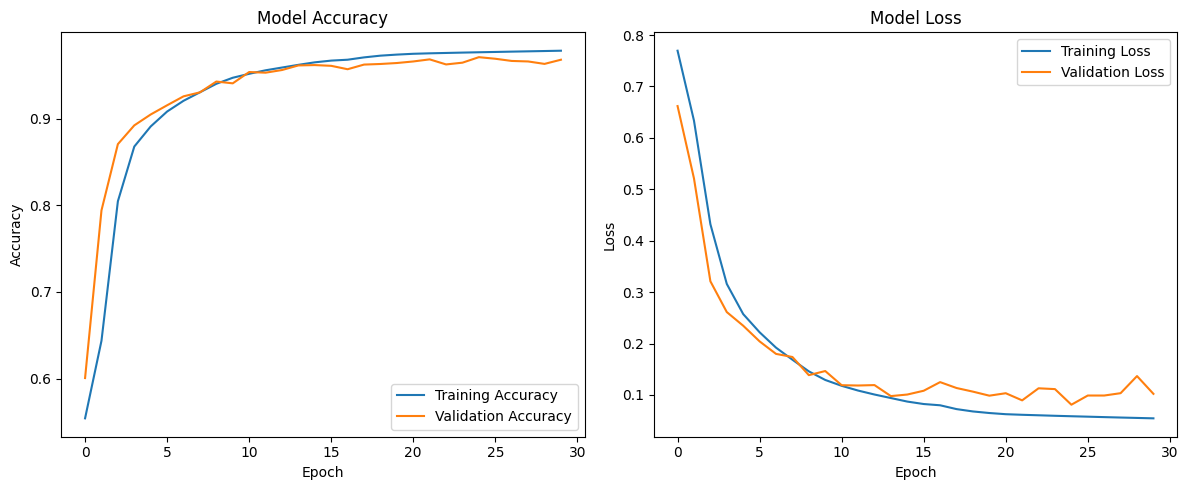

In [27]:
import matplotlib.pyplot as plt


has_validation_data = 'val_loss' in history.history


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if has_validation_data:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
if has_validation_data:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [28]:
print("Evaluating model on the test set...")
loss, accuracy = model.evaluate(val_batches)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Evaluating model on the test set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9664 - loss: 0.1022

Test Loss: 0.0977
Test Accuracy: 0.9678


### Model Saving and Prediction

In [29]:
model.save('cat_and_dog.keras')

In [30]:
loaded_model = tf.keras.models.load_model('cat_and_dog.keras')

In [31]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [32]:
def model_predict(image_path, model):
    # This must be IDENTICAL to your training preprocessing
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img_normalized = tf.cast(img, tf.float32) / 255.0


    img_batch = tf.expand_dims(img_normalized, axis=0)

    # Predict
    predicted_masks = model.predict(img_batch)
    return predicted_masks , img


In [33]:
def predict_and_visualize(image_path, model):


    predicted_masks,img = model_predict(image_path, model)

    # The output is (1, H, W, num_classes).
    #  We take the argmax along the
    # class axis to get the final mask (1, H, W).
    pred_mask = tf.argmax(predicted_masks, axis=-1)

    # Remove the batch dimension to get a displayable image (H, W)
    pred_mask = pred_mask[0]
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    # Display the original, un-normalized image
    plt.imshow(tf.keras.utils.array_to_img(img))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask)
    plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


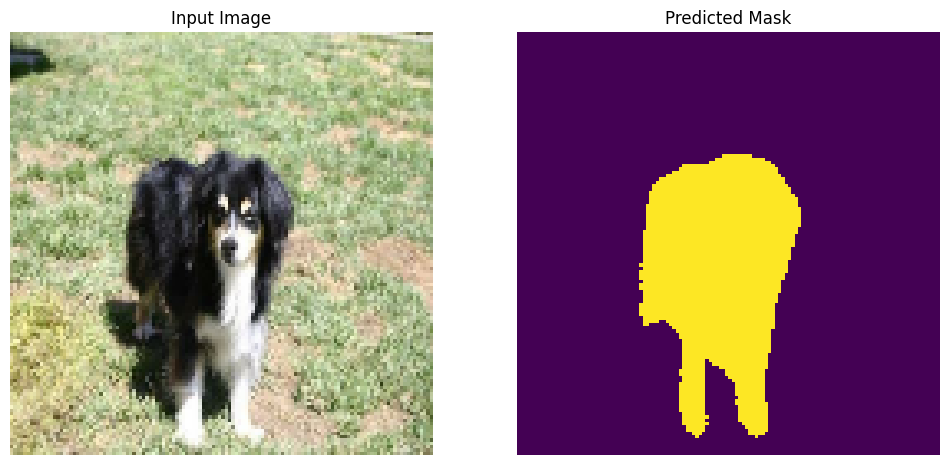

In [37]:
test_path = "/content/New_Cat_Dog/JPEGImages_dog_cat/dog20.jpg"
#test_path = "dataset/car-segmentation/images/003.png"

predict_and_visualize(test_path, loaded_model)

In [38]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def predict_and_show_all_masks(image_path, model, class_encodings):
    """
    Loads an image, gets a prediction, and displays the probability
    mask for every individual class.
    """
    predicted_masks,img = model_predict(image_path, model)


    # --- 3. Visualize the Input and All Masks ---
    num_classes = model.output_shape[-1]

    # Create a figure to display the results
    # We need 1 spot for the input image + num_classes spots for the masks
    plt.figure(figsize=(15, 4 * (num_classes // 3 + 1)))

    # Plot the input image
    plt.subplot(2, 3, 1)
    plt.title("Input Image")
    plt.imshow(tf.keras.utils.array_to_img(img))
    plt.axis('off')

    # Loop through each class and plot its probability mask
    for i in range(num_classes):
        # Extract the mask for the i-th class
        class_mask = predicted_masks[0, :, :, i]

        # Get the class name from our encodings dictionary
        # JSON keys are strings, so we convert the index `i` to a string
        class_name = class_encodings.get(str(i), f"Class {i}")

        plt.subplot(2, 3, i + 2)
        plt.title(f"Mask: {class_name}")
        # Display the mask as a heatmap. 'viridis' is a good colormap for this.
        plt.imshow(class_mask, cmap='viridis')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


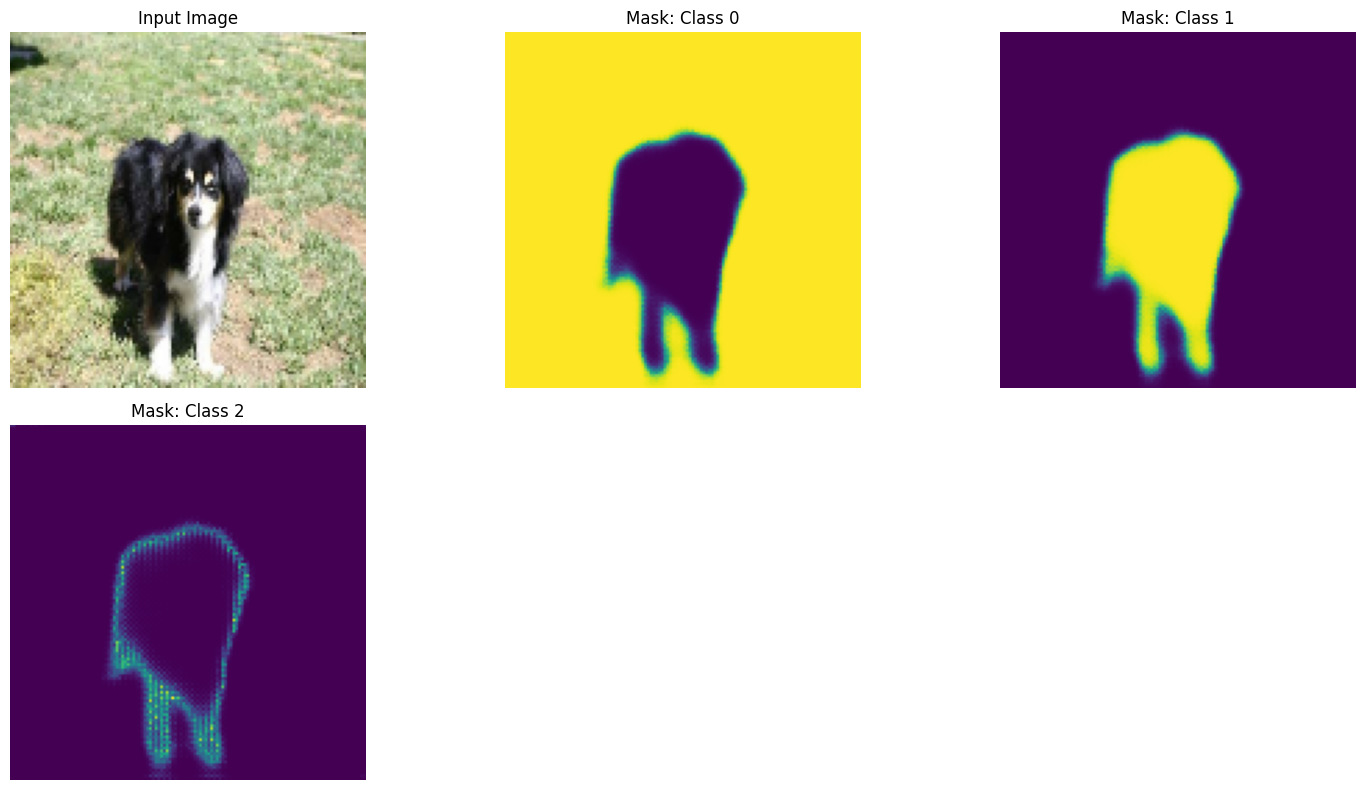

In [39]:
generic_encodings = {str(i): f"Class {i}" for i in range(NUM_CLASSES)}

predict_and_show_all_masks(test_path, loaded_model, generic_encodings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


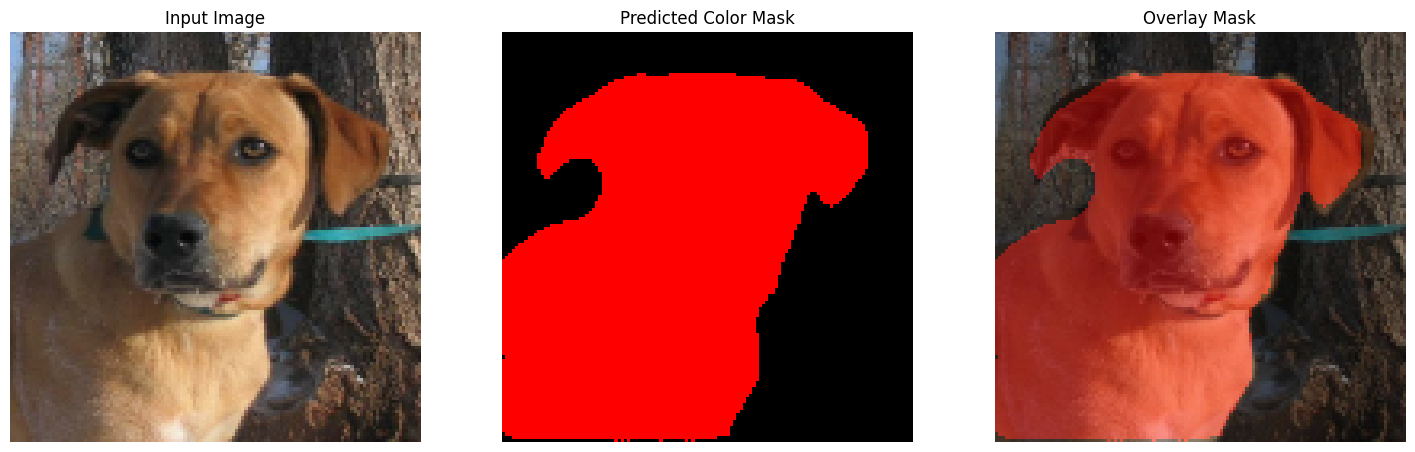

In [ ]:
import numpy as np
import cv2

# 1. Define a color for each of your 5 classes (0 to 4)
COLOR_MAP = np.array([
    [0, 0, 0],       # Class 0: Black (Background)
    [255, 0, 0],     # Class 1: Red (Dog)
    [0, 0, 255]      # Class 2: Blue (Cat)
], dtype=np.uint8)

def mask_to_rgb(mask, color_map):
    rgb_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_idx, color in enumerate(color_map):
        rgb_mask[mask == class_idx] = color
    return rgb_mask


def predict_and_visualize_color(image_path, model, color_map):
    predicted_masks, img = model_predict(image_path, model)
    pred_mask = tf.argmax(predicted_masks, axis=-1)[0].numpy()

    # Convert mask to color
    color_mask = mask_to_rgb(pred_mask, color_map)

    # Convert original image tensor for display
    input_image_numpy = tf.keras.utils.img_to_array(img, dtype=np.uint8)

    # Blend the input image and the color mask for an overlay effect
    overlay = cv2.addWeighted(input_image_numpy, 0.6, color_mask, 0.4, 0)

    # Display the results
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(input_image_numpy)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Predicted Color Mask")
    plt.imshow(color_mask)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Overlay Mask")
    plt.imshow(overlay)
    plt.axis('off')

    plt.show()


test_path = "/content/New_Cat_Dog/JPEGImages_dog_cat/dog51.jpg"
predict_and_visualize_color(test_path, loaded_model, COLOR_MAP)